In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import numpy as np
import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectrum as spectrum
import darkhistory.spec.spectra as spectra
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tfl
import matplotlib
import matplotlib.pyplot as plt
import pickle

np.set_printoptions(threshold=np.nan)
matplotlib.rcParams['figure.figsize'] = [10,10]


from scipy import integrate
from astropy.io import fits
from tqdm import tqdm_notebook as tqdm

In [3]:
transfer_func_table = pickle.load(open("/Users/hongwan/Dropbox (MIT)/Photon Deposition/transfer_func_table.raw","rb"))

In [4]:
eng = transfer_func_table.in_eng
tf_rs_arr = transfer_func_table.rs

In [5]:
#Initialize
eng_ind = 99
mwimp = eng[eng_ind]
print(mwimp)
coarsen_factor = 10

rs_list = np.exp(np.arange(np.log(tf_rs_arr[0]), 
                           np.log(tf_rs_arr[-1]), 
                           -transfer_func_table.dlnz*coarsen_factor)
                )

# Initial injection is 2 photons, to match up with what we have in file.
photon_spec_init = spectools.rebin_N_arr(np.array([2]), 
                                        np.array([mwimp]), 
                                        eng)
                                       
photon_spec_init.rs = rs_list[0]

207661.364379


In [6]:
if coarsen_factor > 1:
    transfer_func_table.coarsen(coarsen_factor, delete_tfs=False)

In [7]:
transfer_func_table.at_val('rs',rs_list)

In [8]:
photon_spectra = spectools.evolve(photon_spec_init, transfer_func_table, save_steps=True)
fin_phot_spec = spectools.evolve(photon_spec_init, transfer_func_table, end_rs=13)

In [9]:
file_name = {99: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_5.328E+00_xe_1.000E-04.fits",
            199: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_7.183E+00_xe_1.000E-04.fits",
            298: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.020E+00_xe_1.000E-04.fits",
            299: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_9.038E+00_xe_1.000E-04.fits", 
            399: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.089E+01_xe_1.000E-04.fits",
            499: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_2049_logE_1.275E+01_xe_1.000E-04.fits",
            2993: "/Users/hongwan/Dropbox (MIT)/Photon Deposition/tf_z_3.100E+01_nstep_18_logE_9.038E+00_xe_1.000E-04.fits"}

file = fits.open(file_name[eng_ind])

file_eng = file[1].data['energy'][0,:]
file_rs = file[1].data['redshift'][0,:]
file_photonspectrum = file[1].data['photonspectrum'][0,:,:]

In [10]:
# file_spectra = spectrum.Spectra([spectrum.Spectrum(file_eng, photspec, rs) 
#                    for photspec,rs in zip(file_photonspectrum, file_rs)], 
#                 rebin_eng = eng)

file_spectra = spectra.Spectra([spectrum.Spectrum(file_eng, photspec, rs) 
                   for photspec,rs in zip(file_photonspectrum, file_rs)])

file_spectra_orig = spectra.Spectra([spectrum.Spectrum(file_eng, photspec, rs) 
                   for photspec,rs in zip(file_photonspectrum, file_rs)])

/Users/hongwan/GitHub/DarkHistory/darkhistory/spec/spectrum.py:605: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)


[0.0001, 10000000000000.0, 1e-22, 1000.0]

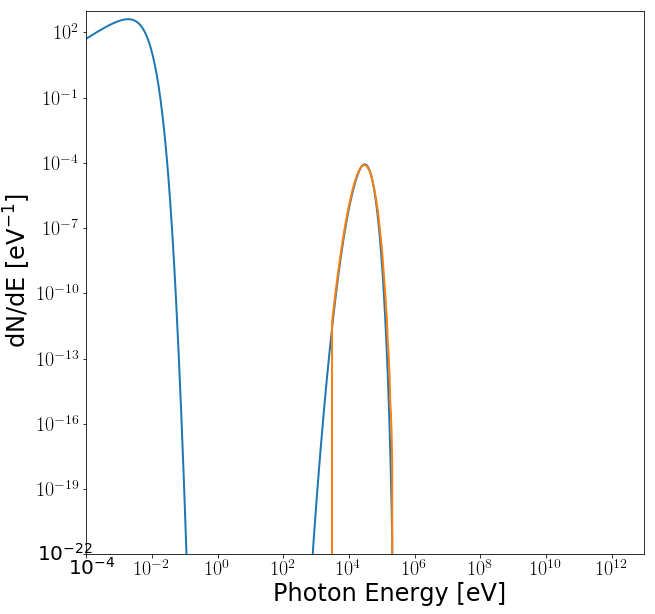

In [11]:
rs_to_plot = 5

photon_spectra.rebin(file_spectra.eng)

ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

file_spectra.plot(ax, ind=rs_to_plot, indtype='rs', linewidth=2)
photon_spectra.plot(ax, ind=rs_to_plot, indtype='rs', linewidth=2)

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/dE [eV$^{-1}$]',fontsize=24)
plt.axis([1e-4, 1e13, 1e-22, 1e3])


/Users/hongwan/GitHub/DarkHistory/darkhistory/spec/spectrum.py:339: RuntimeWarning: divide by zero encountered in true_divide
  invSpec = Spectrum(self.eng, 1/self.dNdE, self.rs)
/Users/hongwan/GitHub/DarkHistory/darkhistory/spec/spectrum.py:254: RuntimeWarning: invalid value encountered in multiply
  return Spectrum(self.eng, self.dNdE*other.dNdE, self.rs)


[4.1953937803349932, 27.467052747379142, 24.36109041803871, 21.606348952473059, 19.163112448790702]


[1000.0, 10000000000.0, 0.001, 100000.0]

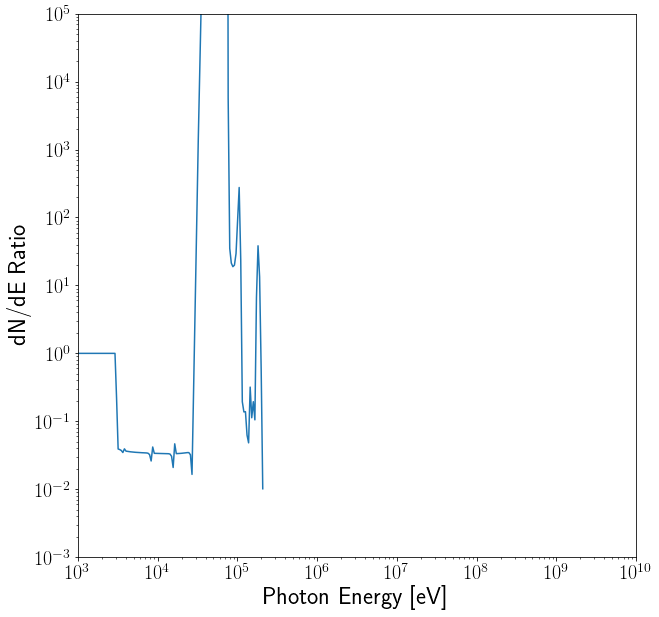

In [12]:
photon_spectra = photon_spectra.at_rs(file_spectra.rs, bounds_err=False)

ratio = (photon_spectra-file_spectra)/file_spectra

ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

ratio.plot(ax, ind=2, abs_plot=True, indtype='ind')
ax.set_xscale('log')
ax.set_yscale('log')
print([ratio.rs[2000],ratio.rs[121],ratio.rs[241],ratio.rs[361],ratio.rs[481]])

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/dE Ratio',fontsize=24)
plt.axis([1e3, 1e10, 1e-3, 1e5])

In [13]:
utils.compare_arr([file_spectra[1].eng, file_spectra[1].dNdE, photon_spectra[1].dNdE])
print(file_spectra[1].rs)

[[  1.02296232e-04   1.85688110e+03   0.00000000e+00]
 [  1.07048086e-04   1.94242834e+03   0.00000000e+00]
 [  1.12020673e-04   2.03187952e+03   0.00000000e+00]
 [  1.17224246e-04   2.12541382e+03   0.00000000e+00]
 [  1.22669536e-04   2.22321143e+03   0.00000000e+00]
 [  1.28367769e-04   2.32546338e+03   0.00000000e+00]
 [  1.34330696e-04   2.43236987e+03   0.00000000e+00]
 [  1.40570612e-04   2.54413403e+03   0.00000000e+00]
 [  1.47100384e-04   2.66097534e+03   0.00000000e+00]
 [  1.53933476e-04   2.78311987e+03   0.00000000e+00]
 [  1.61083979e-04   2.91079858e+03   0.00000000e+00]
 [  1.68566636e-04   3.04425610e+03   0.00000000e+00]
 [  1.76396877e-04   3.18374561e+03   0.00000000e+00]
 [  1.84590847e-04   3.32953247e+03   0.00000000e+00]
 [  1.93165443e-04   3.48189478e+03   0.00000000e+00]
 [  2.02138345e-04   3.64111646e+03   0.00000000e+00]
 [  2.11528055e-04   3.80749854e+03   0.00000000e+00]
 [  2.21353936e-04   3.98134424e+03   0.00000000e+00]
 [  2.31636247e-04   4.16298